In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset

block_size = 3

def build_dataset(words):
    X,Y = [],[]

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] +[ix] #crop and append

    X =torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y
    
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) #80%
Xdev, Ydev = build_dataset(words[n1:n2]) #10%
Xte, Yte = build_dataset(words[n2:]) #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [33]:
# MLP Revisted


n_embd = 10 #the dimensionality  of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g=torch.Generator().manual_seed(2147483647) #for replroducability
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #*0.2
b1 = torch.randn(n_hidden, generator = g) *0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) *0.01
b2 = torch.randn(vocab_size, generator=g) * 0


#BatchNorm Parameters

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros(1, n_hidden)
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # no of parameters
for p in parameters:
    p.required_grad = True

12097


#### How to magic number of 0.1 for W1, etc.

In [30]:
(torch.randn(10000) * 0.2).std()

tensor(0.2018)

In [31]:
# fan in is 30 as there are 3 concatinated together 10+10+10
(5/3) / (30 ** 0.5)

0.3042903097250923

tensor(-0.0118) tensor(0.9949)
tensor(-0.0026) tensor(0.9785)


(array([6.87005056e-05, 2.29001685e-05, 4.58003371e-05, 4.58003371e-05,
        2.06101517e-04, 2.06101517e-04, 5.03803708e-04, 1.03050758e-03,
        1.67171230e-03, 2.15261584e-03, 3.02282225e-03, 5.93114365e-03,
        9.66387112e-03, 1.61675190e-02, 2.63809941e-02, 3.72585742e-02,
        5.79374264e-02, 8.80511480e-02, 1.24485316e-01, 1.75140489e-01,
        2.30077993e-01, 2.84626195e-01, 3.45380342e-01, 3.99722442e-01,
        4.33477290e-01, 4.31393375e-01, 4.06569592e-01, 3.62326466e-01,
        3.03037930e-01, 2.39879265e-01, 1.83178448e-01, 1.32798077e-01,
        9.80814218e-02, 6.31128645e-02, 4.34874200e-02, 2.61519925e-02,
        1.65797220e-02, 1.23889912e-02, 7.21355309e-03, 4.14493050e-03,
        2.51901854e-03, 1.48851095e-03, 9.38906910e-04, 5.26703876e-04,
        4.35103202e-04, 2.29001685e-04, 9.16006741e-05, 9.16006741e-05,
        4.58003371e-05, 4.58003371e-05]),
 array([-5.48559904, -5.26726004, -5.04892103, -4.83058203, -4.61224302,
        -4.39390402, 

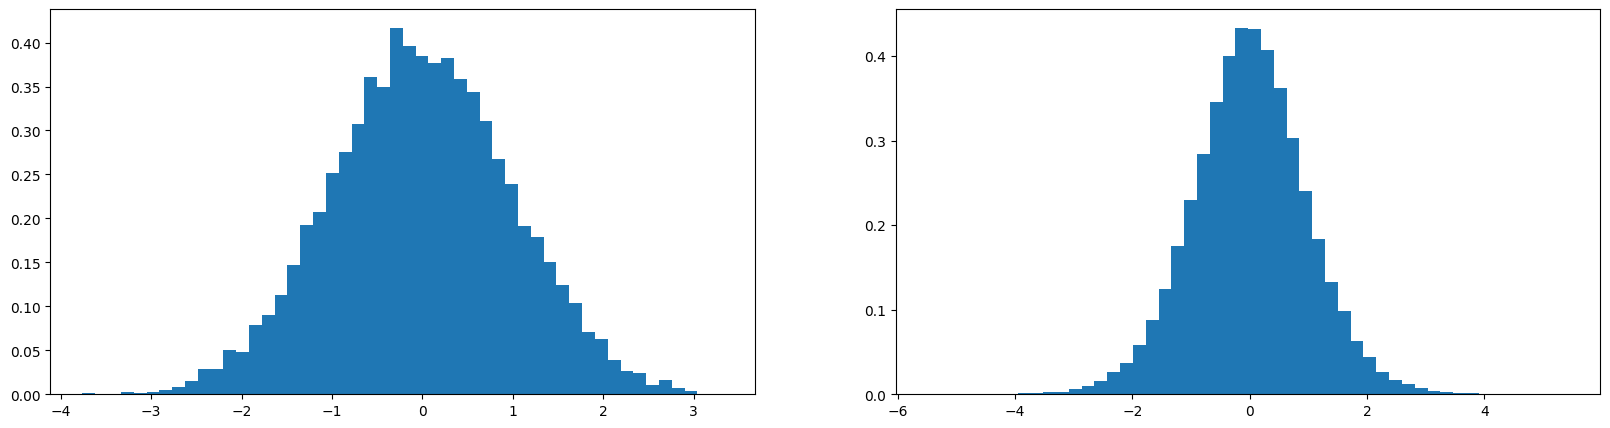

In [25]:
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5  # square root of the fanin. Use this for initializing. Good rule of thumb
y = x @ w
print(x.mean(),x.std())
print(y.mean(),y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True)

#### Contd.

In [34]:
for p in parameters:
    p.requires_grad = True

In [35]:
# same optimization as last notebook

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] #batchX,Y

    #forward pass

    emb = C[Xb] #embed the char into vectors
    embcat = emb.view(emb.shape[0],-1) #concatinate the values
    #Linear layer
    hpreact = embcat @ W1 # +b1 #hiddent layer preactivation

    #BatchNorm Layer

    bnmeani = hpreact.mean(0, keepdim = True)
    bnstdi = hpreact.std(0, keepdim = True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi


    # non-linearity
    h = torch.tanh(hpreact) #hidden layer
    logits = h@W2 +b2 #output layer
    loss = F.cross_entropy(logits, Yb) #loss funtion


    #backward pass

    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.1 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track status

    if i % 10000 == 0: #print once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    #break


      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.4630
 120000/ 200000: 1.9545
 130000/ 200000: 2.3377
 140000/ 200000: 2.4067
 150000/ 200000: 2.2954
 160000/ 200000: 1.9649
 170000/ 200000: 1.9333
 180000/ 200000: 2.0775
 190000/ 200000: 1.8108


#### TO check what the optimisation of the tanh function is like

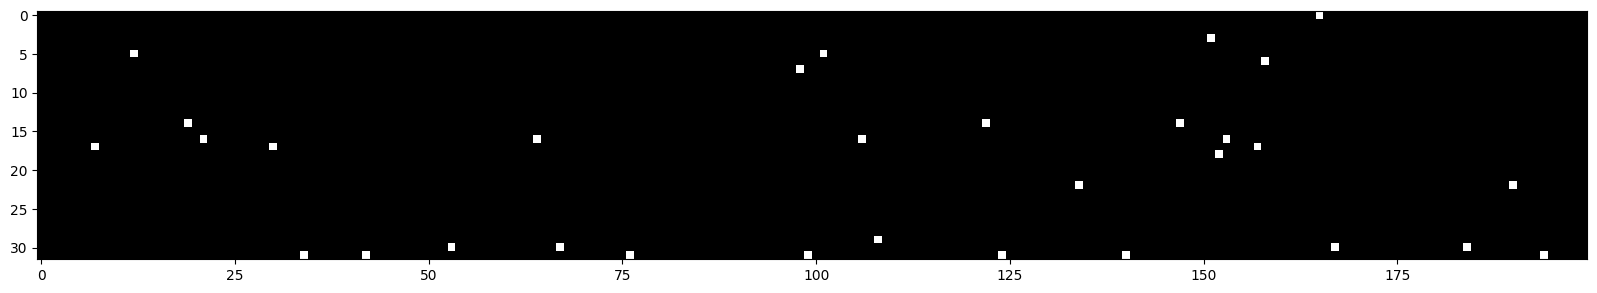

In [12]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation = 'nearest')

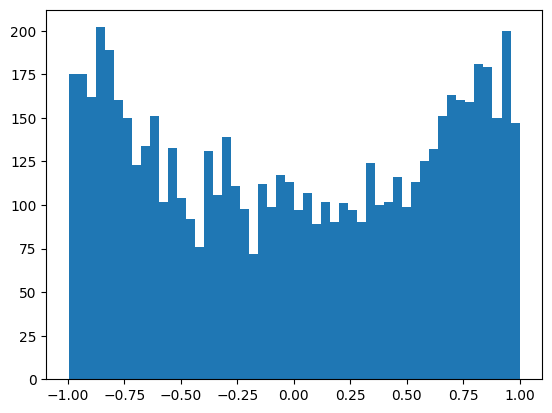

In [13]:
plt.hist(h.view(-1).tolist(),50);

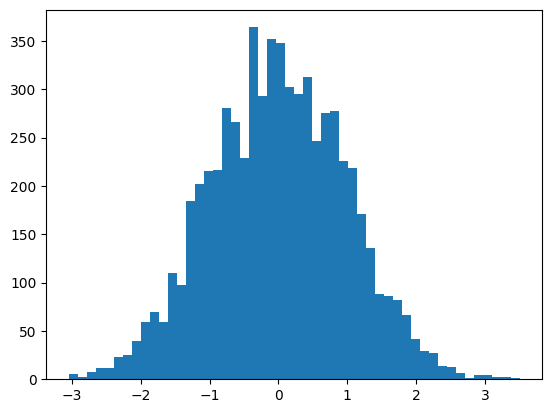

In [14]:
plt.hist(hpreact.view(-1).tolist(),50);

### Continue

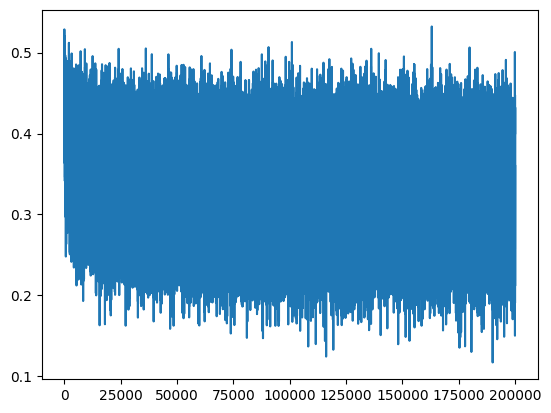

In [39]:
plt.plot(lossi)

In [40]:
# calibrating the batch norm at the end of training

with torch.no_grad():
    #pass the training through the set
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat@W1 # +b1
    #measure the mean/std deviation over the entire training set
    bnmean = hpreact.mean(0, keepdim = True)
    bnstd = hpreact.std(0,keepdim = True)

In [41]:
@ torch.no_grad() # this decorator disables gradient tracking

def split_loss(split):
    x,y ={
        'train':(Xtr, Ytr),
        'val':(Xdev, Ydev),
        'test':(Xte, Yte)
    }[split]

    emb = C[x] #(N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size)
    hpreact = embcat @ W1 # +b1
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True))
    hpreact = bngain * (hpreact - bnmean_running)/bnstd_running
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h@ W2 +b2 #(N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2171082496643066
val 2.2567427158355713


#### Batch Normalization

In [42]:
hpreact.shape

torch.Size([182625, 200])

In [43]:
hpreact.mean(0, keepdim = True).shape

torch.Size([1, 200])

In [44]:
hpreact.std(0, keepdim = True).shape

torch.Size([1, 200])

In [49]:
hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True))/hpreact.std(0, keepdim = True) +bnbias

hpreact

tensor([[-0.6498,  0.5186,  1.0296,  ..., -0.1734,  0.3977,  0.1317],
        [ 1.9554,  1.0500,  0.7529,  ..., -2.7597,  1.2370,  1.6374],
        [-2.1190,  1.9585, -0.2640,  ...,  1.2041,  0.5037, -1.5028],
        ...,
        [ 1.0792, -3.0755, -0.0199,  ...,  0.8514, -0.6443,  1.1202],
        [-1.0859,  0.2306, -1.0821,  ...,  1.3784,  0.0223, -0.7483],
        [-0.8150, -0.0353, -1.1649,  ...,  0.7845, -2.1376,  0.8596]])

In [46]:
#batch normalization gain 

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1, n_hidden))

#### Contd.